In [1]:
# important imports for this notebook
from absl import logging
import flax
import jax.numpy as jnp
import jax
from matplotlib import pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
#import tensorflow as tf
#tf.config.experimental.set_visible_devices([], "GPU")

import optax
from flax.training import train_state
#from flax.metrics import tensorboard

logging.set_verbosity(logging.INFO)

In [2]:
# make sure we are on GPU
from jax.lib import xla_bridge

print(xla_bridge.get_backend().platform)

gpu


In [5]:
# Load in a dataset - start with mnist

# These commands break up the load command into it's parts for more controls
ds_builder = tfds.builder('cifar10')
ds_builder.download_and_prepare()
# 60000 training samples - no shuffle, no batch causes this to return a tensor of
# all of the data instead of a tensorflow dataset structure - we won't use tf.data
# here and just want to convert to numpy - these return dictionaries
train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))

# convert to 0 - 1 range for neural network training - don't want an arbitrary weight
# which could cause large gradients and difficult training.
train_ds['image'] = jnp.float32(train_ds['image']) / 255.0
test_ds['image'] = jnp.float32(test_ds['image']) / 255.0

INFO:absl:Load dataset info from /home/don/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Reusing dataset cifar10 (/home/don/tensorflow_datasets/cifar10/3.0.2)
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/don/tensorflow_datasets/cifar10/3.0.2.
INFO:absl:Constructing tf.data.Dataset cifar10 for split train, from /home/don/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/don/tensorflow_datasets/cifar10/3.0.2.
INFO:absl:Constructing tf.data.Dataset cifar10 for split test, from /home/don/tensorflow_datasets/cifar10/3.0.2
2024-06-01 19:05:02.400045: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1635] failed to alloc 1073741824 bytes on host: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-06-01 19:05:03.072504: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1635] failed to alloc 966367744 bytes on host: CUDA_ERROR_OUT_OF_MEMORY: out of memory
2024-06-01 19:05:03.746841: E external/xl

In [6]:
train_ds['image'][0].shape

(32, 32, 3)

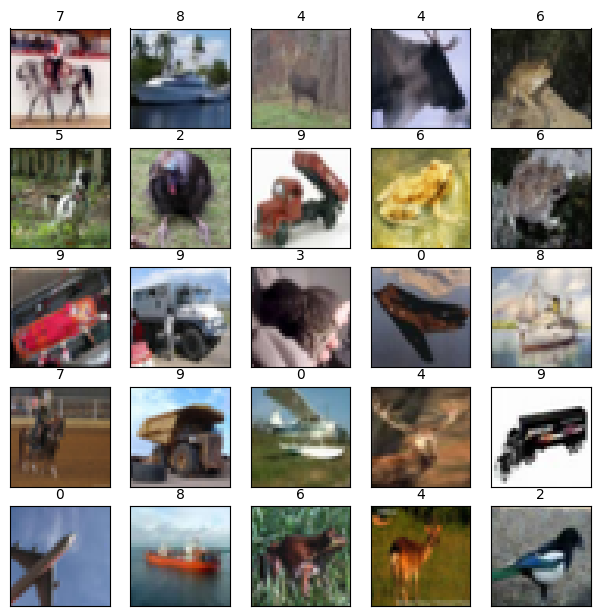

In [7]:
# Always good to check the data to make sure it loaded in properly
# Helper functions for images.

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img)
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title, fontsize=10)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(1.5 * n, 1.5 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    show_img(img, axs[i // n][i % n], title)

show_img_grid(
    [train_ds['image'][idx] for idx in range(25)],
    [f'{train_ds["label"][idx]}' for idx in range(25)],
)
     

In [8]:
%load_ext tensorboard
%tensorboard --logdir='flax_runs'

Launching TensorBoard...

In [15]:
# set up a convolutional model for image data in flax
from flax import linen as nn

class CNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        # this is like the sequential model from Haiku
        x = nn.Conv(features=16, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = x.reshape((x.shape[0], -1)) #flatten the outputs
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)

        # Need 10 output logits (1 per number) - thesse are assumed
        # to be log(probabilites) and will be fed into a softmax
        # layer at evaluation time. the softmax could also be placed
        # here
        x = nn.Dense(features=10)(x)
        
        return x

In [16]:
# test the model
batch_size = 8
learning_rate = 0.001

rng = jax.random.key(0)

model = CNN()

batch = jnp.ones([1, 32, 32, 3])

rng, init_rng = jax.random.split(rng)

# initialize the model (i.e. generate random weights / parameters )
params = model.init(init_rng, batch)['params']

# params has to go in a kwarg
model.apply({'params': params}, batch).shape

(1, 10)

In [17]:
# We need a function to apply the gradients to the model, which will
# update the parameters - can be used to update the model, or we 
# can ignore the gradients and calculate stats for the test set
@jax.jit
def apply_model(state, images, labels):
    
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, images)
        one_hot = jax.nn.one_hot(labels, 10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, logits
    
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return grads, loss, accuracy

In [18]:
# simulate one training run
# initialize optax with a particular training algorithm
tx = optax.adam(learning_rate=learning_rate)

# we then store the state of the training (current parameters, state of optax, and the function to apply)
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)
rng, init_rng = jax.random.split(rng)

train_ds_size = len(train_ds['image'])
# Once we have a random permutation of data, this is how many times we 
# will need ot divide it up to get the required batches
steps_per_epoch = train_ds_size // batch_size

# Get a random permutation
perms = jax.random.permutation(rng, len(train_ds['image']))
perms = perms[: steps_per_epoch * batch_size]  # skip incomplete batch
perms = perms.reshape((steps_per_epoch, batch_size))

# So perms will just be a list of indcies into the original training dataset

# This is what one batch of the permutation looks like then
batch_images = train_ds['image'][perms[0], ...]
batch_labels = train_ds['label'][perms[0], ...]

# 1 - apply model - apply the model to the current batch images, get the logits,
# get the loss, and calculate the gradients over the current batch
grads, loss, accuracy = apply_model(state, batch_images, batch_labels)

# 2 - apply the gradients to update the parameters and then update the state 
# variable (it will internally keep track of the step number)
state = state.apply_gradients(grads=grads)

# 3 - now we could do it all over again

In [19]:
batch_images.shape

(16, 32, 32, 3)

In [20]:
# then we can put this into a full training loop - this is 1 epoch, i.e. 
# one full run through all of the distinct data. Generally you will need 
# to run many epochs to fully train a network though.
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    epoch_loss = []
    epoch_accuracy = []

    rng, input_rng = jax.random.split(rng)

    # We should log the data somehow. Tensorflow is the standard for this, but
    # we should incorporate the clu tools next
    #summary_writer = tensorboard.SummaryWriter('./models/test1')
    # We can add some descriptive hyperparameters for each test
    # This should obviously go into some kind of config library, of which many 
    # exist for this application
    #summary_writer.hparams({'optimzier': 'adam', 'learning_rate': learning_rate, 'epochs': num_epochs, 'batch_size': batch_size})

    train_ds_size = len(train_ds['image'])
    # Once we have a random permutation of data, this is how many times we 
    # will need ot divide it up to get the required batches
    steps_per_epoch = train_ds_size // batch_size

    # Get a random permutation
    perms = jax.random.permutation(input_rng, len(train_ds['image']))
    perms = perms[: steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))

    # So perms will just be a list of indcies into the original training dataset

    for perm in perms:
        batch_images = train_ds['image'][perm, ...]
        batch_labels = train_ds['label'][perm, ...]

        grads, loss, accuracy = apply_model(state, batch_images, batch_labels)

        state = state.apply_gradients(grads=grads)

        epoch_loss.append(loss)
        epoch_accuracy.append(accuracy)

    train_loss = np.mean(epoch_loss)
    train_accuracy = np.mean(epoch_accuracy)

    # We should apply the model to the test set to get an unbiased metric
    _, test_loss, test_accuracy = apply_model(
        state, test_ds['image'], test_ds['label']
    )


    logging.info(
            'epoch:% 3d, train_loss: %.4f, train_accuracy: %.2f, test_loss: %.4f,'
            ' test_accuracy: %.2f'
            % (
                epoch,
                train_loss,
                train_accuracy * 100,
                test_loss,
                test_accuracy * 100,
            )
        )
    
    #summary_writer.scalar('train_loss', train_loss, epoch)
    #summary_writer.scalar('train_accuracy', train_accuracy, epoch)
    #summary_writer.scalar('test_loss', test_loss, epoch)
    #summary_writer.scalar('test_accuracy', test_accuracy, epoch)

    #summary_writer.flush()

2024-06-01 19:11:48.068710: W external/tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 758.19MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-01 19:11:48.068833: W external/tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 758.19MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-01 19:11:48.068891: W external/tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 758.19MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-01 19:11:49.601993: E external/xla/xla/service/slow_operation_alarm.cc:

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1679380280 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  119.25MiB
              constant allocation:         0B
        maybe_live_out allocation:    2.03MiB
     preallocated temp allocation:    1.56GiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:    1.68GiB
              total fragmentation:    21.8KiB (0.00%)
Peak buffers:
	Buffer 1:
		Size: 625.00MiB
		Operator: op_name="jit(apply_model)/jit(main)/jvp(CNN)/Conv_0/conv_general_dilated[window_strides=(1, 1) padding=((1, 1), (1, 1)) lhs_dilation=(1, 1) rhs_dilation=(1, 1) dimension_numbers=ConvDimensionNumbers(lhs_spec=(0, 3, 1, 2), rhs_spec=(3, 2, 0, 1), out_spec=(0, 3, 1, 2)) feature_group_count=1 batch_group_count=1 precision=None preferred_element_type=None]" source_file="/tmp/ipykernel_8571/3206433981.py" source_line=8
		XLA Label: custom-call
		Shape: f32[10000,16,32,32]
		==========================

	Buffer 2:
		Size: 312.50MiB
		Operator: op_name="jit(apply_model)/jit(main)/jvp(CNN)/Conv_1/conv_general_dilated[window_strides=(1, 1) padding=((1, 1), (1, 1)) lhs_dilation=(1, 1) rhs_dilation=(1, 1) dimension_numbers=ConvDimensionNumbers(lhs_spec=(0, 3, 1, 2), rhs_spec=(3, 2, 0, 1), out_spec=(0, 3, 1, 2)) feature_group_count=1 batch_group_count=1 precision=None preferred_element_type=None]" source_file="/tmp/ipykernel_8571/3206433981.py" source_line=11
		XLA Label: custom-call
		Shape: f32[10000,32,16,16]
		==========================

	Buffer 3:
		Size: 312.50MiB
		Operator: op_name="jit(apply_model)/jit(main)/transpose(jvp(CNN))/select_n" source_file="/tmp/ipykernel_8571/3206433981.py" source_line=12
		XLA Label: fusion
		Shape: f32[10000,32,16,16]
		==========================

	Buffer 4:
		Size: 156.25MiB
		Operator: op_name="jit(apply_model)/jit(main)/jvp(CNN)/div" source_file="/tmp/ipykernel_8571/3206433981.py" source_line=10
		XLA Label: fusion
		Shape: f32[10000,16,16,16]
		==========================

	Buffer 5:
		Size: 117.19MiB
		XLA Label: fusion
		Shape: f32[10000,3,32,32]
		==========================

	Buffer 6:
		Size: 117.19MiB
		Entry Parameter Subshape: f32[10000,32,32,3]
		==========================

	Buffer 7:
		Size: 78.12MiB
		Operator: op_name="jit(apply_model)/jit(main)/transpose(jvp(CNN))/Dense_0/dot_general[dimension_numbers=(((1,), (1,)), ((), ())) precision=None preferred_element_type=None]" source_file="/tmp/ipykernel_8571/3206433981.py" source_line=16
		XLA Label: fusion
		Shape: f32[10000,8,8,32]
		==========================

	Buffer 8:
		Size: 2.00MiB
		Entry Parameter Subshape: f32[2048,256]
		==========================

	Buffer 9:
		Size: 2.00MiB
		Operator: op_name="jit(apply_model)/jit(main)/transpose(jvp(CNN))/Dense_0/transpose[permutation=(1, 0)]" source_file="/tmp/ipykernel_8571/3206433981.py" source_line=16
		XLA Label: custom-call
		Shape: f32[2048,256]
		==========================

	Buffer 10:
		Size: 39.1KiB
		Entry Parameter Subshape: s32[10000]
		==========================

	Buffer 11:
		Size: 18.0KiB
		XLA Label: fusion
		Shape: f32[32,16,3,3]
		==========================

	Buffer 12:
		Size: 18.0KiB
		Entry Parameter Subshape: f32[3,3,16,32]
		==========================

	Buffer 13:
		Size: 18.0KiB
		XLA Label: fusion
		Shape: f32[3,3,16,32]
		==========================

	Buffer 14:
		Size: 10.0KiB
		Entry Parameter Subshape: f32[256,10]
		==========================

	Buffer 15:
		Size: 10.0KiB
		Operator: op_name="jit(apply_model)/jit(main)/transpose(jvp(CNN))/Dense_1/transpose[permutation=(1, 0)]" source_file="/tmp/ipykernel_8571/3206433981.py" source_line=23
		XLA Label: fusion
		Shape: f32[256,10]
		==========================



In [58]:
train_accuracy

0.14324078